## **MLP para classificação binária**
**Dataset Ionosphere**
- Dataset de texto com previsão da existência de uma estrutura na atomosfera com dados de um radar
- Classificação "good" significa evidência de estrutura na ionosfera e "bad" o contrário
- 34 atributos contínuos (numéricos) e o 35º é a classificação de "good"/"bad" com "g"/"b"
- 350 instâncias

## Pipeline de um processo de Deep Learning implementado em PyTorch:

    1. Preparar os Dados
    2. Definir o Modelo
    3. Treinar o Modelo
    4. Avaliar o Modelo
    5. Usar o Modelo


## Melhoramento do Modelo


In [1]:
!pip3 install torch torchvision

  Using cached torch-2.2.2-cp312-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (6.6 kB)
  Using cached filelock-3.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 356.7 kB/s eta 0:00:0000:0100:07
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 171.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 223.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 367.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 616.4 kB/s eta 0:00:00a 0:00:01


In [2]:
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install numpy

In [5]:
# Confirmar a instalação

import torch
print(torch.__version__)

2.2.2


## Imports

In [6]:
# pytorch mlp for binary classification
import time
import pandas as pd #implementa mesmo a representação das tabelas
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_



import random
import os
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(24)

Random seed set as 24


In [3]:
#####ir buscar o dataset:
#!wget -c https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv -O ionosphere.csv

In [7]:
#Constants

#path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
PATH = 'ionosphere.csv'
#setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('global free:', round(torch.cuda.mem_get_info()[0]/1024**3,1), 'GB')
    print('global total:', round(torch.cuda.mem_get_info()[1]/1024**3,1), 'GB')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



#force cpu
#device = torch.device("cpu")
print('Using device:', device)
print()


EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

Using device: cpu



## *1. Preparar os Dados

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path):
        # ler o ficheiro csv para um dataframe
        df = pd.read_csv(path, header=None)
        # separar os inputs e os outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # garantir que os inputs sejam floats
        self.X = self.X.astype('float32') #'float64' processa, mas demora mais tempo 
        # fazer o encoding dos outputs (label) e garantir que sejam floats
        self.y = LabelEncoder().fit_transform(self.y) #faz o fit e transforma no self.y o 'g' e o 'b' em 0 e 1 #fit_transform - transforma dados categóricos em numéricos
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))   
        
    # número de casos no dataset
    def __len__(self):
        return len(self.X)
 
    # retornar um caso
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # retornar índices para casos de treino e de teste
    def get_splits(self, n_test=0.33):
        # calcular o tamanho para o split
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calcular o split do houldout
        return random_split(self, [train_size, test_size], generator=torch.Generator().manual_seed(42)) #vai receber em formato numpy e vai receber em tensor - formato que o torch usa
        #a estrutura numpy não funciona nos gpu - então o tensor é uma estrutura equivalente para o gpu
    
        # Stratified Sampling for train and test
    def get_splits_strat(self, n_test=0.33):
        train_X, test_X, train_y, test_y = train_test_split(self.X, self.y, 
                                             test_size=n_test,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=self.y)
        train = TensorDataset(torch.from_numpy(train_X),torch.from_numpy(train_y))
        test = TensorDataset(torch.from_numpy(test_X),torch.from_numpy(test_y))
        return train, test
    
# preparar o dataset
def prepare_data(path):
    # criar uma instância do dataset
    dataset = CSVDataset(path)
    # calcular o split
    train, test = dataset.get_splits()
    print('sem strat',type(train))
    # preparar os data loaders - classe do torch que permite a iteração sobre os dados (acede aos dados e fornecer em batches à rede)
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False) #shuffle é sempre o mesmo a embaralhar - garantido através dos vários treinos
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar o dataset
def prepare_data_strat(path):
    # criar uma instância do dataset
    dataset = CSVDataset(path)
    # calcular o split
    train, test = dataset.get_splits_strat()
    print('com strat',type(train))
    # preparar os data loaders
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all


# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data(PATH) #verificar se os dados estão a correr corretamente

# sanity check
x,y = next(iter(train_dl)) #vai buscar uma iteração dos dados de treino
print(x.shape, y.shape) #ver o formato e ver se está certo
x,y = next(iter(test_dl))
print(x.shape, y.shape)

# preparar os dados
train_s_dl, test_s_dl,  train_s_dl_all, test_s_dl_all = prepare_data_strat(PATH)

# sanity check
x,y = next(iter(train_s_dl))
print(x.shape, y.shape)
x,y = next(iter(test_s_dl))
print(x.shape, y.shape)

sem strat <class 'torch.utils.data.dataset.Subset'>
torch.Size([235, 34]) torch.Size([235, 1])
torch.Size([116, 34]) torch.Size([116, 1])
com strat <class 'torch.utils.data.dataset.TensorDataset'>
torch.Size([235, 34]) torch.Size([235, 1])
torch.Size([116, 34]) torch.Size([116, 1])


## *1.1 Visualizar os Dados

In [27]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=None)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos teste, input: {x.shape}, output: {y.shape}")

visualize_data(PATH)
visualize_dataset(train_dl, test_dl)

0   1        2        3        4        5        6        7        8   \
0     1   0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1     1   0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2     1   0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3     1   0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4     1   0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   
..   ..  ..      ...      ...      ...      ...      ...      ...      ...   
346   1   0  0.83508  0.08298  0.73739 -0.14706  0.84349 -0.05567  0.90441   
347   1   0  0.95113  0.00419  0.95183 -0.02723  0.93438 -0.01920  0.94590   
348   1   0  0.94701 -0.00034  0.93207 -0.03227  0.95177 -0.03431  0.95584   
349   1   0  0.90608 -0.01657  0.98122 -0.01989  0.95691 -0.03646  0.85746   
350   1   0  0.84710  0.13533  0.73638 -0.06151  0.87873  0.08260  0.88928   

          9   ...       25       26       27       28       29       30  \
0    0.03760  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090  0.42267   
1   -0.04549  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593 -0.16626   
2    0.01198  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365  0.60436   
3    0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099  0.25682   
4   -0.16399  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197 -0.05707   
..       ...  ...      ...      ...      ...      ...      ...      ...   
346 -0.04622  ... -0.04202  0.83479  0.00123  1.00000  0.12815  0.86660   
347  0.01606  ...  0.01361  0.93522  0.04925  0.93159  0.08168  0.94066   
348  0.02446  ...  0.03193  0.92489  0.02542  0.92120  0.02242  0.92459   
349  0.00110  ... -0.02099  0.89147 -0.07760  0.82983 -0.17238  0.96022   
350 -0.09139  ... -0.15114  0.81147 -0.04822  0.78207 -0.00703  0.75747   

          31       32       33  34  
0   -0.54487  0.18641 -0.45300   g  
1   -0.06288 -0.13738 -0.02447   b  
2   -0.24180  0.56045 -0.38238   g  
3    1.00000 -0.32382  1.00000   b  
4   -0.59573 -0.04608 -0.65697   g  
..       ...      ...      ...  ..  
346 -0.10714  0.90546 -0.04307   g  
347 -0.00035  0.91483  0.04712   g  
348  0.00442  0.92697 -0.00577   g  
349 -0.03757  0.87403 -0.16243   g  
350 -0.06678  0.85764 -0.06151   g  

[351 rows x 35 columns]

Quantidade de casos de Treino:235
Quantidade de casos de Teste:116
Shape tensor batch casos treino, input: torch.Size([235, 34]), output: torch.Size([235, 1])
Shape tensor batch casos teste, input: torch.Size([116, 34]), output: torch.Size([116, 1])


## *1.2 Verificar balanceamento do dataset

casos_treino: 235
g_Train:  156
b_Train:  79
g_Train/b_Train:  1.9746835443037976
casos_test: 116
g_Test:  69
b_Test:  47
g_Test/b_Test:  1.4680851063829787


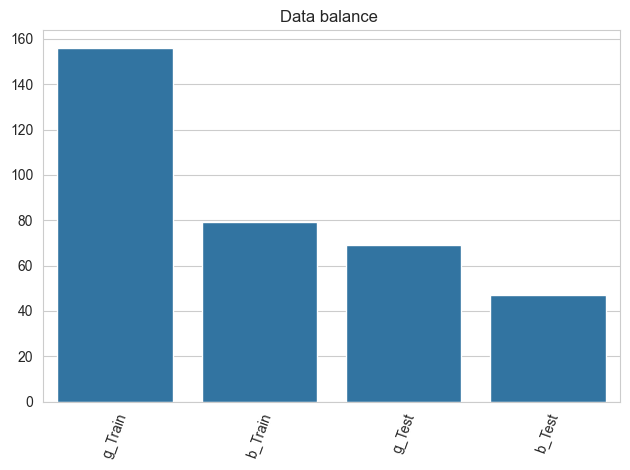

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(train_dl, test_dl):
    _, y_train = next(iter(train_dl))                            
    _, y_test = next(iter(test_dl))

    sns.set_style('whitegrid')
    casos_treino=len(y_train) # calcular o nº de casos de treino
    casos_test=len(y_test) # calcular o nº de casos de teste
    b_Train=np.count_nonzero(y_train == 0) # calcular o nº de 0 nos casos de treino
    g_Train = np.count_nonzero(y_train == 1) # calcular o nº de 1 nos casos de treino
    b_Test=np.count_nonzero(y_test == 0) # calcular o nº de 0 nos casos de teste
    g_Test = np.count_nonzero(y_test == 1) # calcular o nº de 1 nos casos de teste
    print("casos_treino:",casos_treino)
    print("g_Train: ", g_Train)
    print("b_Train: ", b_Train)
    print("g_Train/b_Train: ", g_Train/b_Train) # rácio de g em b
    print("casos_test:",casos_test)
    print("g_Test: ", g_Test)
    print("b_Test: ", b_Test)
    print("g_Test/b_Test: ", g_Test/b_Test) # rácio de g em b

    grafico=sns.barplot(x=['g_Train','b_Train', 'g_Test', 'b_Test'], 
                        y=[g_Train,b_Train, g_Test, b_Test])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
visualize_holdout_balance(train_dl_all, test_dl_all)

casos_treino: 235
g_Train:  151
b_Train:  84
g_Train/b_Train:  1.7976190476190477
casos_test: 116
g_Test:  74
b_Test:  42
g_Test/b_Test:  1.7619047619047619


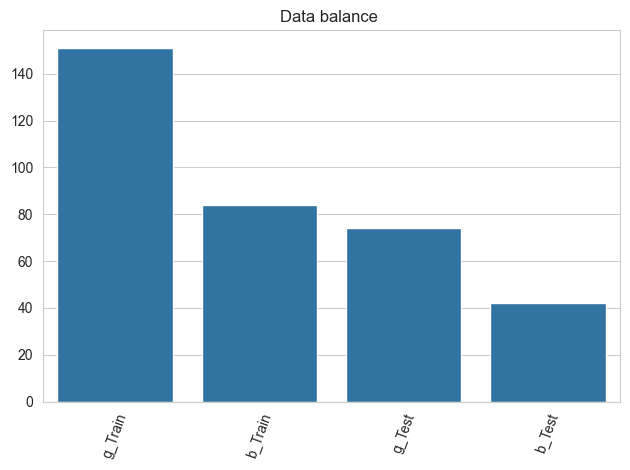

In [29]:
visualize_holdout_balance(train_s_dl_all, test_s_dl_all)

## *2. Definir o Modelo

In [11]:
#### Instalar o torchinfo
!pip3 install torchinfo

In [12]:
from torchinfo import summary

# Definição da classe para o modelo
class MLP(Module):
    # definir elementos do modelo
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input para a primeira camada - Linear - ReLU - layer de ativação
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu') # He initialization
        self.act1 = ReLU() #função de ativação não estão nos nodos
        # segunda camada - Linear - ReLU - camada de 8 nodos -  10 entradas
        self.hidden2 = Linear(10, 8) 
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # terceira camada e output Linear - Sigmoid
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight) # Glorot initialization
        self.act3 = Sigmoid()
 
    # sequência de propagação do input 
    def forward(self, X):
        # input para a primeira camada
        X = self.hidden1(X)
        X = self.act1(X)
        # input para a segunda camada
        X = self.hidden2(X)
        X = self.act2(X)
        # input para a terceira camada e output
        X = self.hidden3(X)
        X = self.act3(X)
        return X
 
# definir a rede neuronal
model1 = MLP(34)
model2 = MLP(34)
# visualizar a rede
batch_size = 32
# sumário da rede
print(summary(model1, input_size=(batch_size, 34), device=device, verbose=0)) #verbose=2 Show weight and bias layers in full detail
model1.to(device) #o summary faz esta tabelinha - 350 (34 x 10 + 10)
model2.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 1]                   --
├─Linear: 1-1                            [32, 10]                  350
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 8]                   88
├─ReLU: 1-4                              [32, 8]                   --
├─Linear: 1-5                            [32, 1]                   9
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 447
Trainable params: 447
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


MLP(
  (hidden1): Linear(in_features=34, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (act3): Sigmoid()
)

## *3. Treinar o Modelo

In [13]:
## Instalar o livelossplot
!pip3 install livelossplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
#versão com display de gráfico
from livelossplot import PlotLosses #permite visualizar a curva de aprendizagem

# define accuracy function
def binary_acc(pred, target):
    pred_tag = torch.round(pred)

    correct_results_sum = (pred_tag == target).sum().float()
    #acc = correct_results_sum/target.shape[0]
    #acc = acc*100
    acc=correct_results_sum 
    return acc


# treino do modelo
def train_model(train_dl, model):
    liveloss = PlotLosses() # para visualizarmos o processo de treino
    # definir a função de loss e a função de otimização
    # criterion = BCELoss() # Binary Cross Entropy - precisa de signoid como função de ativação na saida
    criterion = BCEWithLogitsLoss()
    # optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) # stochastic gradient descent
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # iterar as epochs
    for epoch in range(EPOCHS):
        logs = {} # para visualizarmos o processo de treino
        # iterar as batchs
        epoch_loss  = 0.0 # para visualizarmos o processo de treino
        epoch_acc  = 0.0 # para visualizarmos o processo de treino
        for i, (inputs, labels) in enumerate(train_dl): # backpropagation
            # inicializar os gradientes
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad() # coloca os gradientes de todos os parametros a zero
            # calcular o output do modelo - previsao/forward
            outputs = model(inputs)
            # calcular o loss
            loss = criterion(outputs, labels)
            # calcular a accuracy
            acc = binary_acc(outputs, labels)
            #acc = accuracy_score(outputs.detach().cpu().numpy().round(), labels.numpy(), normalize=False)
            # atribuição alteraçoes "In the backward pass we receive a Tensor containing the gradient of the loss
            # with respect to the output, and we need to compute the gradient of the loss with respect to the input.
            loss.backward() #backpropagation
            # update pesos do modelo
            optimizer.step()
            # calcular epochs de loss e epochs de accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        epoch_loss = epoch_loss/len(train_dl.dataset)
        epoch_acc = epoch_acc/len(train_dl.dataset)
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss:.5f} | Acc: {epoch_acc:.3f}')      
        logs['loss'] = epoch_loss # para visualizarmos o processo de treino
        logs['accuracy'] = epoch_acc # para visualizarmos o processo de treino
        liveloss.update(logs) # para visualizarmos o processo de treino
        liveloss.send() # para visualizarmos o processo de treino
 
# treinar o modelo
#%timeit train_model(train_dl, model1)

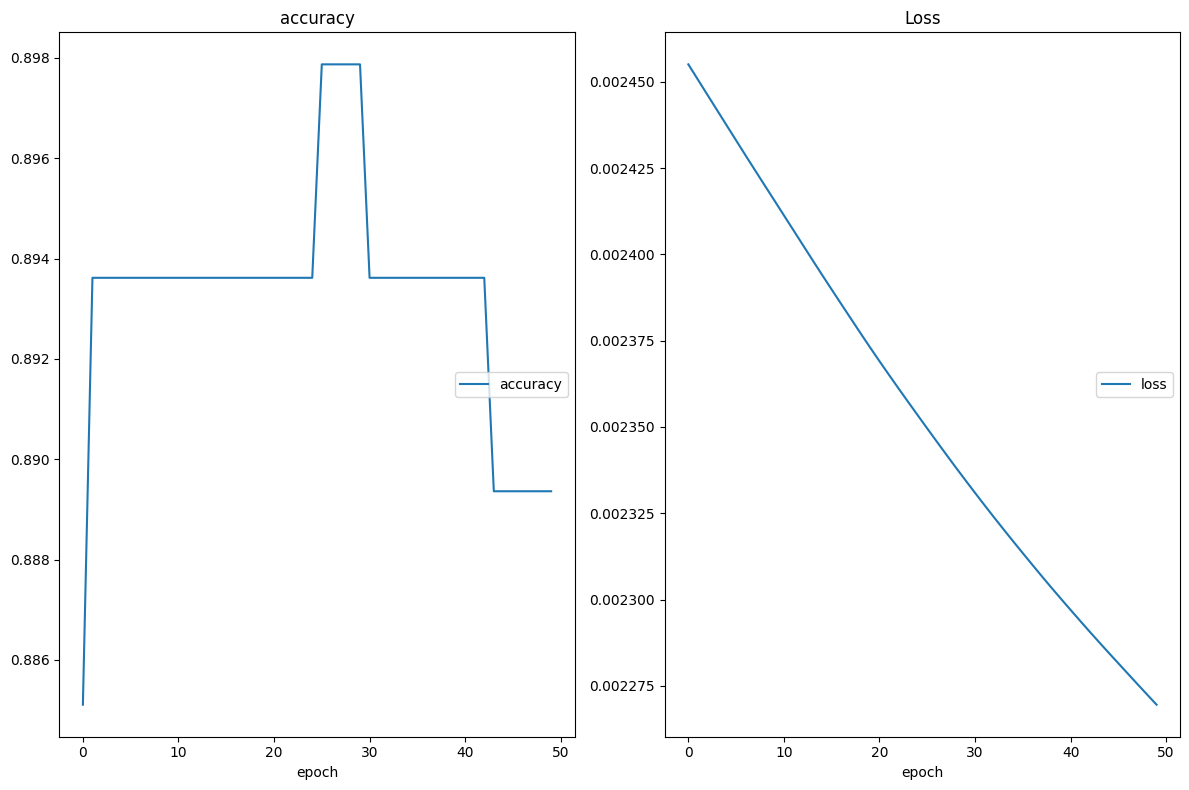

accuracy
	accuracy         	 (min:    0.885, max:    0.898, cur:    0.889)
Loss
	loss             	 (min:    0.002, max:    0.002, cur:    0.002)
Execution time: 35.9 seconds


In [16]:
#%%timeit
# treinar o modelo

it = time.time()
train_model(train_dl, model1)
delta_t= time.time() - it
print(f'Execution time: {delta_t:.3} seconds')

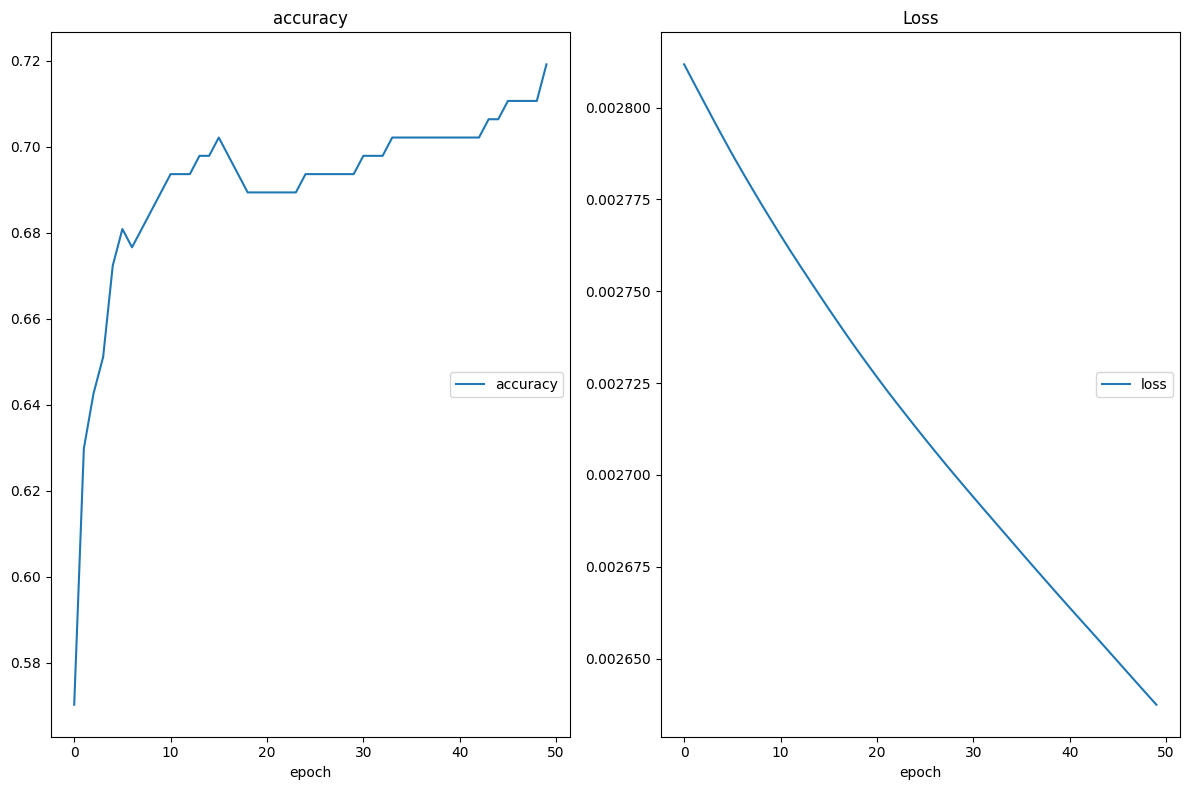

accuracy
	accuracy         	 (min:    0.570, max:    0.719, cur:    0.719)
Loss
	loss             	 (min:    0.003, max:    0.003, cur:    0.003)


In [17]:
#%%timeit
train_model(train_s_dl, model2)

## *4. Avaliar o Modelo

In [30]:
import matplotlib.pyplot as plt

In [31]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    predictions_prob = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        # avaliar o modelo com os casos de teste
        inputs=inputs.to(device)
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.cpu().detach().numpy()
        actual = labels.numpy()
        # arredondar para obter a classe
        predictions_prob.append(yprev) #vamos guardar tambem a probabilidade
        yprev = yprev.round()
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
    predictions_prob = np.vstack(predictions_prob)
    predictions = np.vstack(predictions)
    actual_values =  np.vstack(actual_values)
    return predictions_prob, predictions, actual_values
 
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=['b','g'],yticklabels=['b','g'], annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    


Accuracy: 0.810

real:[1.] probabilidade:[0.90139675] previsão:[1.]
real:[0.] probabilidade:[0.54108876] previsão:[1.]
real:[1.] probabilidade:[0.91465265] previsão:[1.]
real:[0.] probabilidade:[0.28127405] previsão:[0.]
real:[0.] probabilidade:[0.4029602] previsão:[0.]
real:[1.] probabilidade:[0.7754258] previsão:[1.]
real:[0.] probabilidade:[0.15484358] previsão:[0.]
real:[1.] probabilidade:[0.88730145] previsão:[1.]
real:[1.] probabilidade:[0.8851156] previsão:[1.]
real:[1.] probabilidade:[0.74943334] previsão:[1.]
real:[1.] probabilidade:[0.81754935] previsão:[1.]
real:[1.] probabilidade:[0.9105807] previsão:[1.]
real:[1.] probabilidade:[0.80362296] previsão:[1.]
real:[0.] probabilidade:[0.35974023] previsão:[0.]
real:[0.] probabilidade:[0.04166999] previsão:[0.]
real:[0.] probabilidade:[0.42032847] previsão:[0.]
real:[1.] probabilidade:[0.8536951] previsão:[1.]
real:[1.] probabilidade:[0.9230579] previsão:[1.]
real:[0.] probabilidade:[0.06090287] previsão:[0.]
real:[0.] probabilid

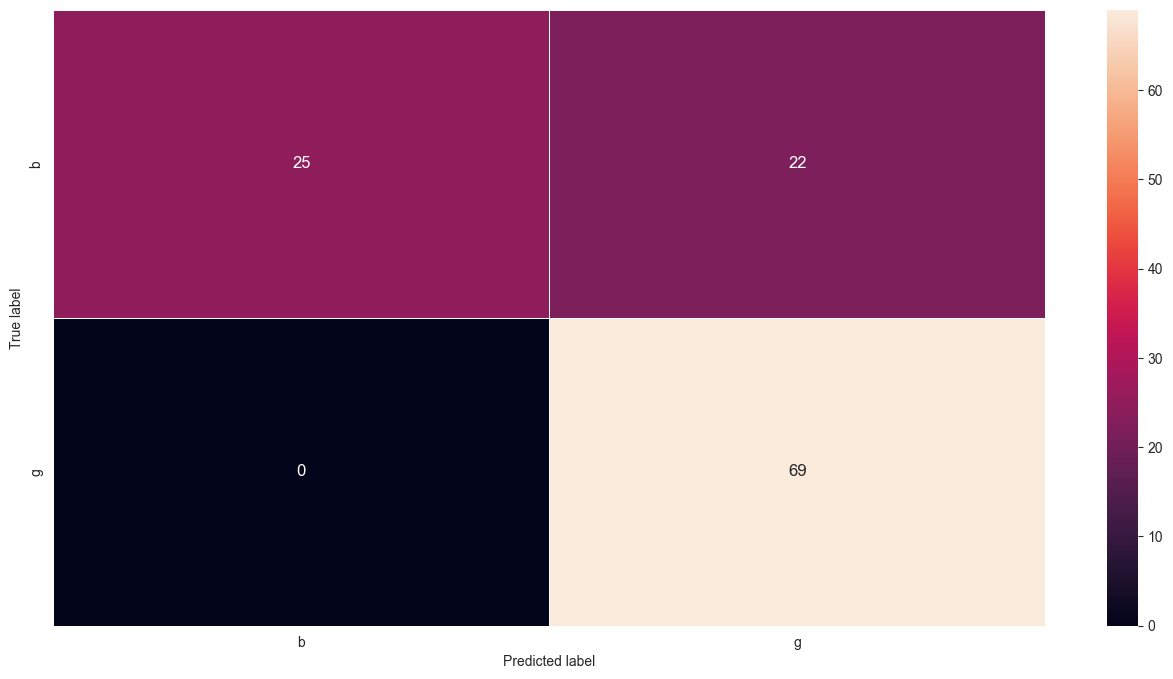

In [32]:
# avaliar o modelo
predictions_prob, predictions, actual_values = evaluate_model(test_dl, model1)
#actuals, predictions = evaluate_model(train_dl, model)
# calcular a accuracy
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')

acertou=0
falhou = 0
for prob, r,p in zip(predictions_prob, actual_values, predictions):
    print(f'real:{r} probabilidade:{prob} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1
print(f'acertou:{acertou} falhou:{falhou}')

# relatório de classificação: precision, recall, f1-score, support vs. 0,1, accuracy, macro avg, weighted avg
print(classification_report(actual_values, predictions))

# matriz confusão
cm = confusion_matrix(actual_values, predictions)
print (cm)
display_confusion_matrix(cm)

Accuracy: 0.724

real:[1.] probabilidade:[0.7031639] previsão:[1.]
real:[0.] probabilidade:[0.6540028] previsão:[1.]
real:[0.] probabilidade:[0.5273321] previsão:[1.]
real:[1.] probabilidade:[0.75015926] previsão:[1.]
real:[1.] probabilidade:[0.7055846] previsão:[1.]
real:[1.] probabilidade:[0.6673689] previsão:[1.]
real:[1.] probabilidade:[0.7357824] previsão:[1.]
real:[1.] probabilidade:[0.7247313] previsão:[1.]
real:[1.] probabilidade:[0.8114819] previsão:[1.]
real:[1.] probabilidade:[0.7814148] previsão:[1.]
real:[0.] probabilidade:[0.48367804] previsão:[0.]
real:[0.] probabilidade:[0.5898873] previsão:[1.]
real:[1.] probabilidade:[0.69221985] previsão:[1.]
real:[1.] probabilidade:[0.82918334] previsão:[1.]
real:[1.] probabilidade:[0.5999876] previsão:[1.]
real:[0.] probabilidade:[0.81794983] previsão:[1.]
real:[1.] probabilidade:[0.7016657] previsão:[1.]
real:[1.] probabilidade:[0.7200803] previsão:[1.]
real:[1.] probabilidade:[0.6343569] previsão:[1.]
real:[0.] probabilidade:[0.5

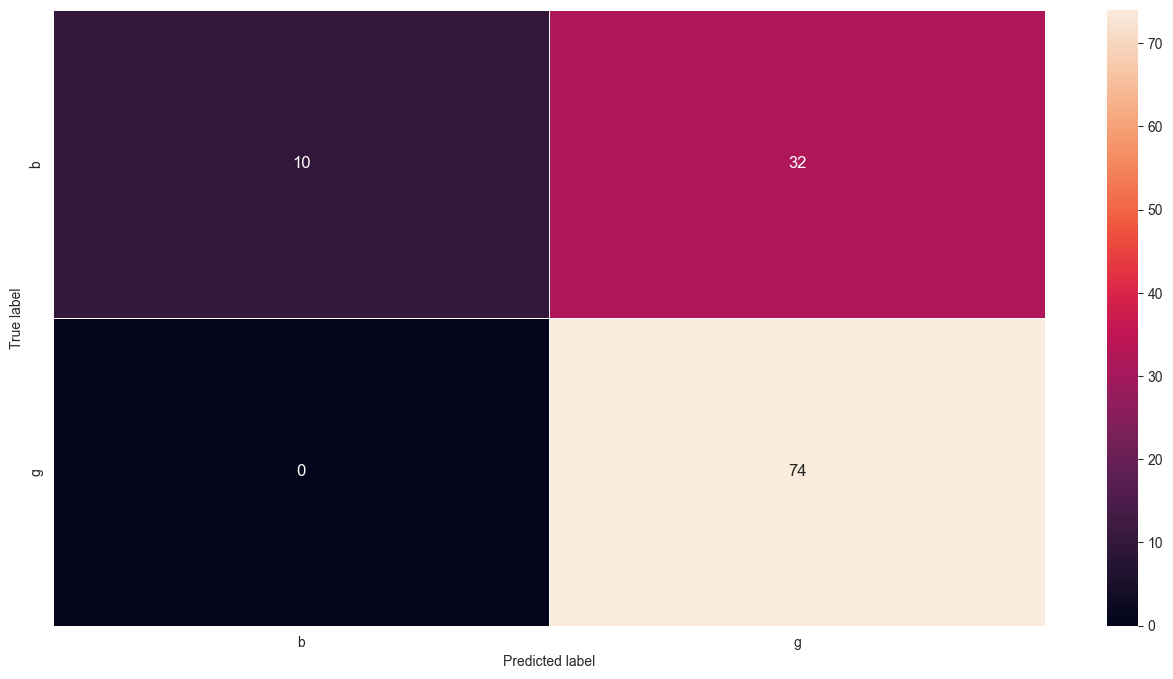

In [33]:
# avaliar o modelo
predictions_prob, predictions, actual_values = evaluate_model(test_s_dl, model2)
#actuals, predictions = evaluate_model(train_dl, model)
# calcular a accuracy
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')

acertou=0
falhou = 0
for prob, r,p in zip(predictions_prob, actual_values, predictions):
    print(f'real:{r} probabilidade:{prob} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1
print(f'acertou:{acertou} falhou:{falhou}')

# relatório de classificação: precision, recall, f1-score, support vs. 0,1, accuracy, macro avg, weighted avg
print(classification_report(actual_values, predictions))

# matriz confusão
cm = confusion_matrix(actual_values, predictions)
print (cm)
display_confusion_matrix(cm)

## *5. Usar o Modelo

In [34]:
# fazer uma previsão utilizando um caso
def predict(row, model):
    # converter row para tensor
    row = Tensor([row])
    # fazer a previsão
    row=row.to(device)
    yprev = model(row)
    # retirar o array numpy
    yprev = yprev.cpu().detach().numpy()
    return yprev
 
# fazer uma única previsão (classe esperada = 1)
row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
yprev = predict(row, model1)
#print('Predicted: %.3f (class=%d)' % (yprev, yprev.round()))
print(f'Predicted: {yprev} (class={yprev.round()})')
yprev = predict(row, model2)
#print('Predicted: %.3f (class=%d)' % (yprev, yprev.round()))
print(f'Predicted: {yprev} (class={yprev.round()})')

Predicted: [[0.69139874]] (class=[[1.]])
Predicted: [[0.66886795]] (class=[[1.]])
